- https://www.robots.ox.ac.uk/~vgg/hzbook/hzbook1/HZepipolar.pdf
- http://www.uio.no/studier/emner/matnat/its/UNIK4690/v16/forelesninger/lecture_7_1-epipolar-geometry.pdf
- https://github.com/marktao99/python/blob/master/CVP/samples/sfm.py#L85

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
def get_row_A(pair, pair_prime):
    x, y = pair[0], pair[1]
    x_p, y_p = pair_prime[0], pair_prime[1]
    return [x*x_p, y*x_p, x_p, x*y_p, y*y_p, y_p, x, y, 1]

def build_A(pairs, pairs_prime):
    A = np.zeros((pairs.shape[0], 9))
    for i, (p, p_p) in enumerate(zip(pairs, pairs_prime)):
        A[i] = get_row_A(p, p_p)
    
    return A

def get_fundemental_matrix(pairs, pairs_prime):
    A = build_A(pairs, pairs_prime)
    u, s, v = np.linalg.svd(A, full_matrices = False)
    f_bar = v[-1].reshape(3,3)
    u_hat, s_hat, v_hat = np.linalg.svd(f_bar, full_matrices = False)
    s_hat[-1] = 0
    f_hat = np.dot(u_hat, np.dot(np.diag(s_hat), v_hat))
    return f_hat

def get_normalisation_matrix(points):
    mean = np.mean(points, axis = 0)
    s = np.sqrt(2) / np.std(points, axis = 0)
    T = np.array([
        [s[0], 0, -s[0] * mean[0]],
        [0, s[1], -s[1] * mean[1]],
        [0, 0, 1]
    ])
    return T

def get_fundemental_matrix_normalised(pairs, pairs_prime):
    
    T = get_normalisation_matrix(pairs[:, :2])
    norm_pairs = np.dot(pairs, T.T)
    
    T_prime = get_normalisation_matrix(pairs_prime[:, :2])
    norm_pairs_prime = np.dot(pairs_prime, T_prime.T)
    
    F = get_fundemental_matrix(norm_pairs, norm_pairs_prime)
    
    denormed_F = np.dot(T_prime.T, np.dot(F, T))
    
    return denormed_F
    

def compute_epipole(F):
    """ 
    Computes the (right) epipole from a 
    fundamental matrix F. 
    (Use with F.T for left epipole.) 
    """
    
    # return null space of F (Fx=0)
    U,S,V = np.linalg.svd(F)
    e = V[-1]
    return e/e[2]

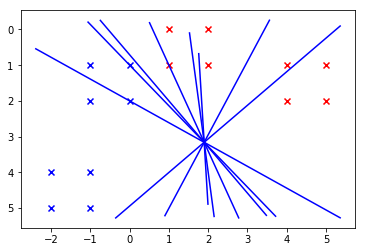

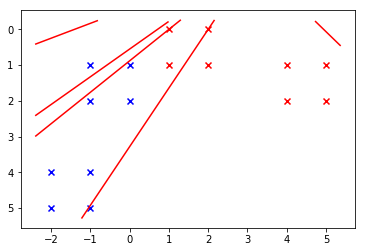

In [5]:
pairs = np.array([
    [0, 1],
    [0, 2],
    [1, 2],
    [1, 1],
    [1, 4],
    [1, 5],
    [2, 5],
    [2, 4]
])
pairs = np.concatenate((pairs, np.ones((pairs.shape[0], 1))), axis = 1)

plt.scatter(pairs[:, 1], pairs[:, 0], marker='x', c='r')

H = np.array([
    [0, 1, 0],
    [-1, 0, 0],
    [0, 0, 1]
]) # simple left rotation, no translation

pairs_prime = H.dot(pairs.T).T

plt.scatter(pairs_prime[:, 1], pairs_prime[:, 0], marker='x', c='b')
plt.gca().invert_yaxis()

F = get_fundemental_matrix_normalised(pairs, pairs_prime)
x_bound = plt.gca().get_xbound()
y_min, y_max = plt.gca().get_ybound()

for p in pairs_prime:
    line = np.dot(F.T, p)
    space = np.linspace(*x_bound, 100)
    
    eq = (line[2] + line[0] * space) / -line[1]
    selector = np.logical_and(y_min < eq, eq < y_max)
    space = space[selector]
    eq = eq[selector]
    
    plt.plot(space, eq, color='b')
    
plt.show()

plt.scatter(pairs[:, 1], pairs[:, 0], marker='x', c='r')
plt.scatter(pairs_prime[:, 1], pairs_prime[:, 0], marker='x', c='b')
plt.gca().invert_yaxis()

for p in pairs:
    line = np.dot(F, p)
    space = np.linspace(*x_bound, 100)
    
    eq = (line[2] + line[0] * space) / -line[1]
    selector = np.logical_and(y_min < eq, eq < y_max)
    space = space[selector]
    eq = eq[selector]
    
    plt.plot(space, eq, color='r')
    
plt.show()

Loading Annotator in data load mode...
Found annotations for images/bridge_left.JPG @ bridge_left_annotation.txt, loading...
Found annotations for images/bridge_right.JPG @ bridge_right_annotation.txt, loading...


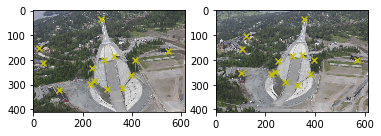

F:
[[ 1.96838865e-06  1.37524107e-05 -4.61625365e-05]
 [-1.04532203e-05  4.72480180e-06 -1.11838877e-02]
 [ 7.92860420e-04  7.71724227e-03 -3.38695807e-01]]



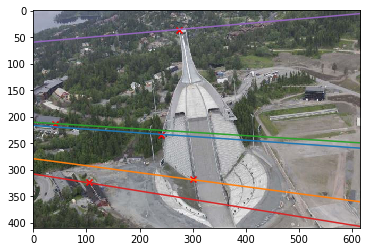

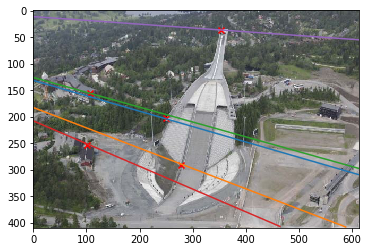

In [91]:
from src.annotator import Annotator
ann = Annotator('images/bridge_left.JPG', 'images/bridge_right.JPG', annotation_mode=False)
ann.display_images(show=True)
points = np.array(ann.coords)
images = ann.images

left = np.concatenate((points[0], np.ones((points[0].shape[0], 1))), axis=1)
right = np.concatenate((points[1], np.ones((points[1].shape[0], 1))), axis=1)

F = get_fundemental_matrix_normalised(left, right)
print('F:\n{}\n'.format(F))

plt.imshow(images[0])
x_bound = plt.gca().get_xbound()
y_min, y_max = plt.gca().get_ybound()

for p, p_p in zip(left[:5], right[:5]):
    line = np.dot(F.T, p_p)
    space = np.linspace(*x_bound, 100)
    
    eq = (line[2] + line[0] * space) / - line[1]
    selector = np.logical_and(y_min < eq, eq < y_max)
    space = space[selector]
    eq = eq[selector]
    
    plt.plot(space, eq)
    plt.scatter(p[0], p[1], marker='x', c='r')
    
plt.show()
    
plt.imshow(images[1])
x_bound = plt.gca().get_xbound()
y_min, y_max = plt.gca().get_ybound()
for p, p_p in zip(left[:5], right[:5]):
    line = np.dot(F, p)
    space = np.linspace(*x_bound, 100)
    
    eq = (line[2] + line[0] * space) / - line[1]
    selector = np.logical_and(y_min < eq, eq < y_max)
    space = space[selector]
    eq = eq[selector]
    
    plt.plot(space, eq)
    plt.scatter(p_p[0], p_p[1], marker='x', c='r')

In [92]:
def fundemental_accuracy(pairs, pairs_prime, F):
    
    lines = np.dot(pairs, F.T)
    distances = np.abs(np.sum(lines * pairs_prime, axis = 1)) # pairwise dot products

    return distances.mean()

In [93]:
avgdist = fundemental_accuracy(left, right, F)
print('fundemental accuracy: {} (Maximum accuracy = 1)'.format(1 - avgdist))

fundemental accuracy: 0.9850611950241874 (Maximum accuracy = 1)


c:\users\rameg\miniconda2\envs\patternrec\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


0 256
117.33629014756944 52.995515371212065


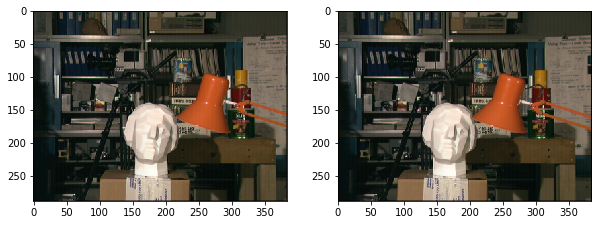

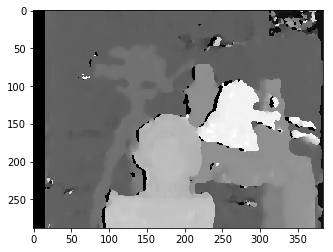

In [96]:
import cv2
from scipy.misc import imread
from src.utils import plot_side_by_side

# image_paths = ['images/coffee_left.jpg', 'images/coffee_right.jpg']
image_paths = ['images/tsukuba/scene1.row3.col1.ppm', 'images/tsukuba/scene1.row3.col2.ppm']
images = [imread(p) for p in image_paths]
norm = lambda im: ((im - im.min()) / (im.max() - im.min()) * 255).astype(np.uint8)
to_grey = lambda im: norm(0.299 * im[:, :, 0] + 0.587 * im[:, :, 1] + 0.114 * im[:, :, 2])

stereo = cv2.StereoSGBM_create(numDisparities=16, blockSize=11, )

min_height = min([im.shape[0] for im  in images])
min_width = min([im.shape[1] for im in images])
rsz_images = [to_grey(im[:min_height, :min_width]) for im in images]

disparity = stereo.compute(rsz_images[0], rsz_images[1])
disparity += 16

print(disparity.min(), disparity.max())
print(disparity.mean(), disparity.std())

plot_side_by_side(images[0], images[1])
plt.show()
plt.imshow(disparity, cmap='gray')